In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from frlearn.base import select_class
from frlearn.classifiers import FRNN
from frlearn.feature_preprocessors import FRFS

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('NIDDK-DF-new-3targets.csv',decimal=",")
df = data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,193,77,49,3.9,19,1,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,1,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,1,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,1,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,1,70,141,20.2,122,86,32,39,0.82,0


In [3]:
print('There is' , df.shape[0] , 'rows')
print('There is' , df.shape[1] , 'columns')

There is 390 rows
There is 15 columns


### Data Preprocessing

In [4]:
df=data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,193,77,49,3.9,19,1,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,1,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,1,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,1,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,1,70,141,20.2,122,86,32,39,0.82,0


# Modelling

In [5]:
df = data.copy()
df['Outcome'].value_counts(normalize=True) #Classes déséquilibrées

0    0.715385
1    0.153846
2    0.130769
Name: Outcome, dtype: float64

In [6]:
df.dtypes

cholesterol         int64
glucose             int64
hdl_chol            int64
chol_hdl_ratio     object
age                 int64
gender              int64
height              int64
weight              int64
bmi                object
systolic_bp         int64
diastolic_bp        int64
waist               int64
hip                 int64
waist_hip_ratio    object
Outcome             int64
dtype: object

In [7]:
# using apply method
df[['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']] = df[['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']].apply(pd.to_numeric)
print(df.dtypes)

cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
gender               int64
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
Outcome              int64
dtype: object


In [8]:
x=df.drop('Outcome',axis=1)
y=df['Outcome']

In [9]:
x.shape

(390, 14)

In [10]:
X_orig = x.to_numpy()

### Feature selection by FRFS

In [11]:
# Create an instance of the FRFS preprocessor and process the data.
preprocessorfrfs = FRFS(n_features=3)
model = preprocessorfrfs(X_orig, y)
X = model(X_orig)

In [12]:
X.shape

(390, 3)

In [13]:
# Create an instance of the FRNN classifier and construct the model.
    
clf = FRNN(upper_weights=None, lower_weights=None, upper_k=1, lower_k=1)
model = clf(X, y)

## Creating train and test sets

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [15]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

## Creating models

In [16]:
preprocessor = make_pipeline(MinMaxScaler())

#PCAPipeline = make_pipeline(StandardScaler(), PCA(n_components=3,random_state=42))

RandomPipeline = make_pipeline(preprocessor,RandomForestClassifier(random_state=42))
AdaPipeline = make_pipeline(preprocessor,AdaBoostClassifier(random_state=42))
SVMPipeline = make_pipeline(preprocessor,SVC(random_state=42,probability=True))
KNNPipeline = make_pipeline(preprocessor,KNeighborsClassifier())
LRPipeline = make_pipeline(preprocessor,LogisticRegression(solver='sag',random_state=42))

# Training models
## Models overview

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [18]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [19]:
dict_of_models = {'RandomForest': RandomPipeline,
'AdaBoost': AdaPipeline,
'SVM': SVMPipeline,
'KNN': KNNPipeline,
'LR': LRPipeline}

In [20]:
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # finding the predicted valued
    y_pred = np.argmax(y_pred_proba,axis=1)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')
    
    N, train_score, test_score = learning_curve(model, X_train, y_train, 
                                               cv=4, scoring='f1', 
                                               train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()
    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(multiclass_roc_auc_score(y_test, y_pred))
    
    from sklearn.metrics import roc_curve
    y_pred_keras = RandomPipeline.predict_proba(X=X_test)
    import scikitplot as skplt
    plot = skplt.metrics.plot_roc(y_test, y_pred_keras)
    plt.show()

In [21]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV

---------------------------------
RandomForest
Accuracy =  0.5256410256410257
-
[[35 10  9]
 [ 6  6  2]
 [ 5  5  0]]
-
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        54
           1       0.29      0.43      0.34        14
           2       0.00      0.00      0.00        10

    accuracy                           0.53        78
   macro avg       0.35      0.36      0.35        78
weighted avg       0.58      0.53      0.55        78

-


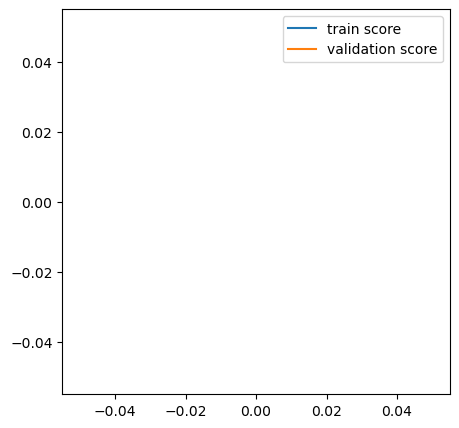

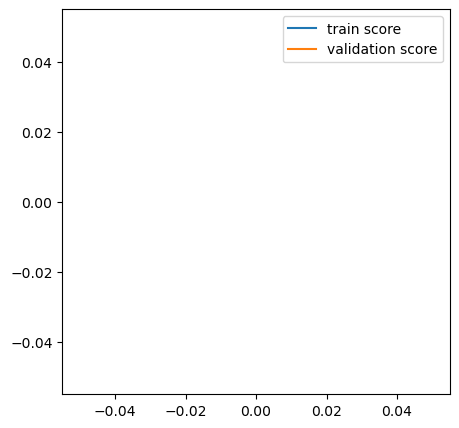

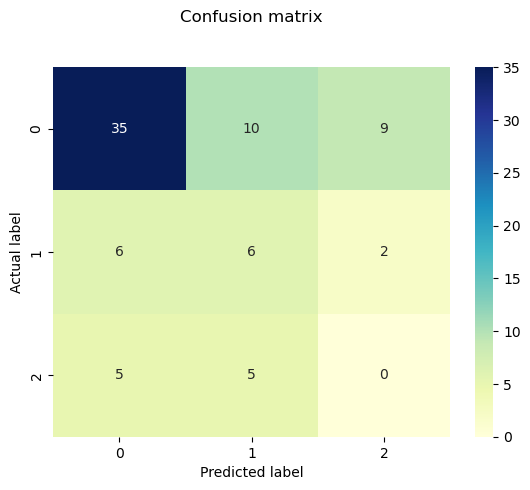

0.5370410895839818


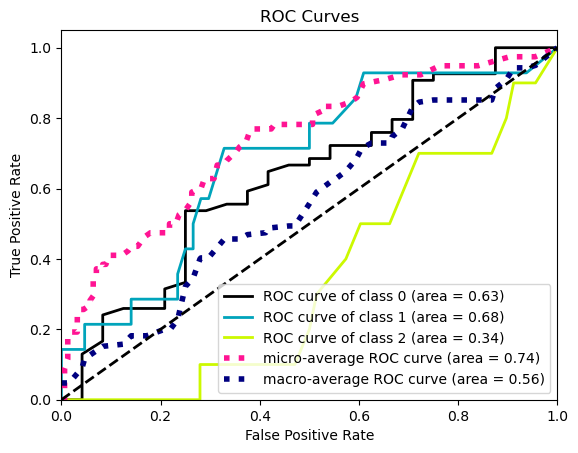

---------------------------------
AdaBoost
Accuracy =  0.44871794871794873
-
[[29 14 11]
 [ 4  6  4]
 [ 6  4  0]]
-
              precision    recall  f1-score   support

           0       0.74      0.54      0.62        54
           1       0.25      0.43      0.32        14
           2       0.00      0.00      0.00        10

    accuracy                           0.45        78
   macro avg       0.33      0.32      0.31        78
weighted avg       0.56      0.45      0.49        78

-


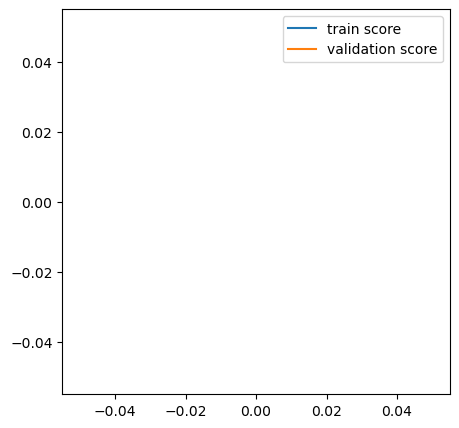

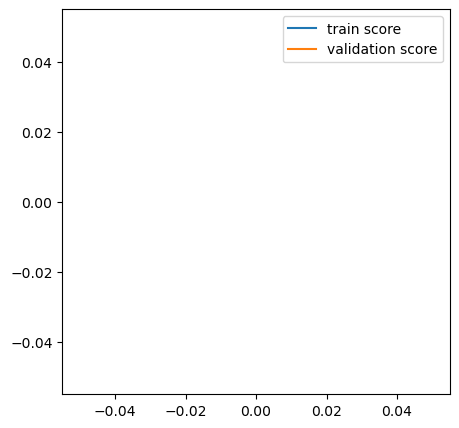

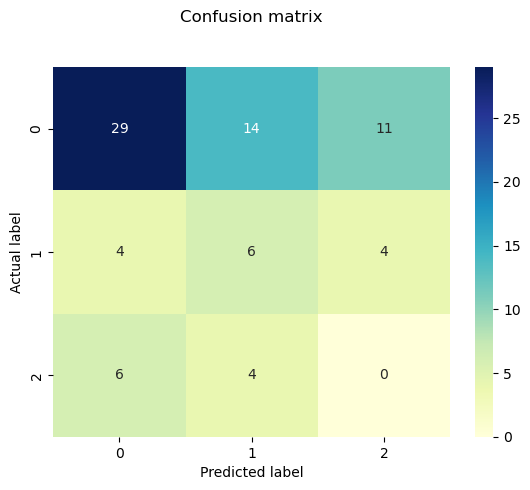

0.5078505939412802


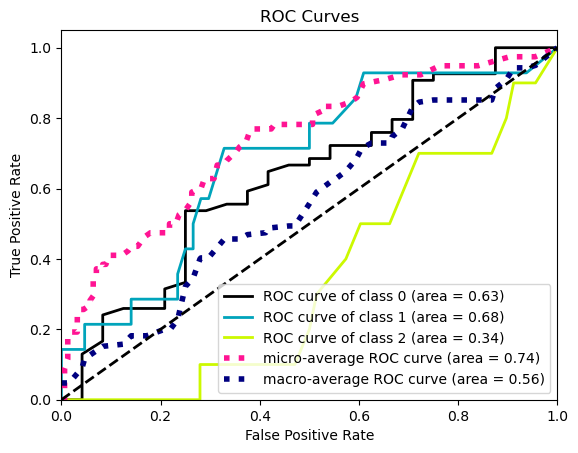

---------------------------------
SVM
Accuracy =  0.4358974358974359
-
[[25 14 15]
 [ 1  8  5]
 [ 4  5  1]]
-
              precision    recall  f1-score   support

           0       0.83      0.46      0.60        54
           1       0.30      0.57      0.39        14
           2       0.05      0.10      0.06        10

    accuracy                           0.44        78
   macro avg       0.39      0.38      0.35        78
weighted avg       0.64      0.44      0.49        78

-


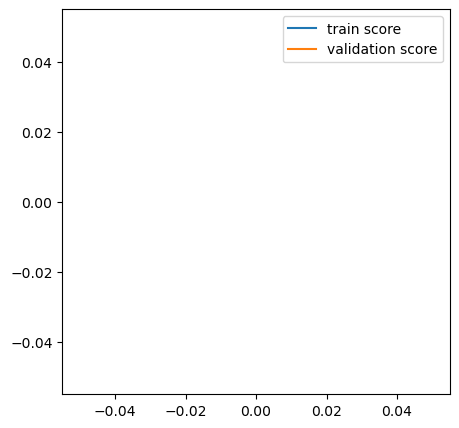

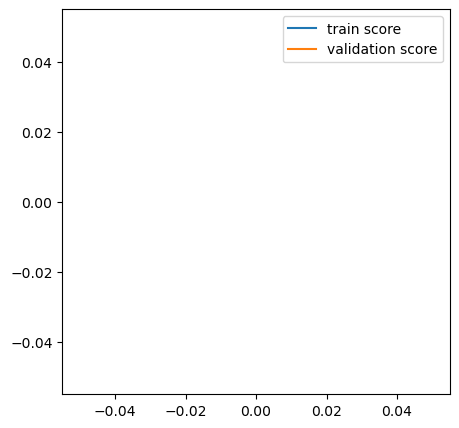

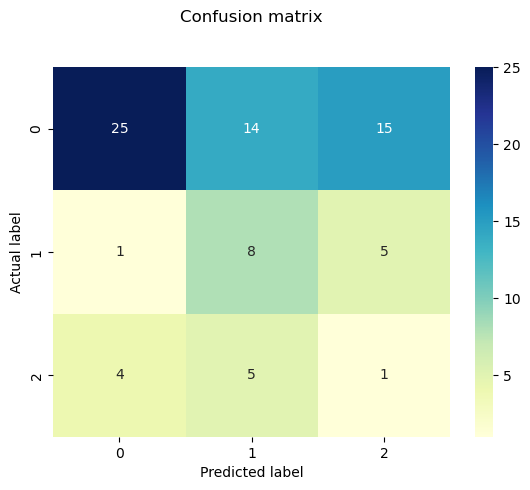

0.5558442589998962


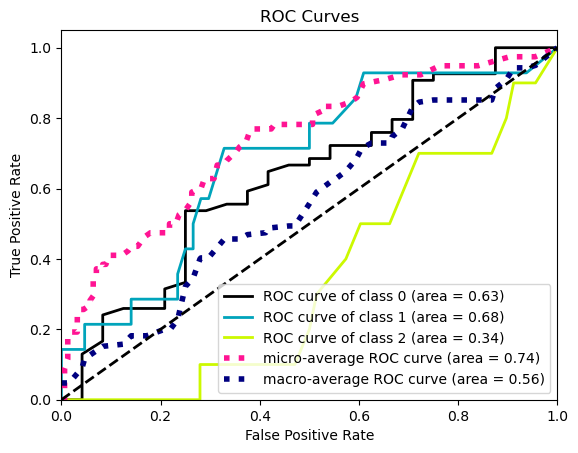

---------------------------------
KNN
Accuracy =  0.4358974358974359
-
[[25 17 12]
 [ 4  7  3]
 [ 4  4  2]]
-
              precision    recall  f1-score   support

           0       0.76      0.46      0.57        54
           1       0.25      0.50      0.33        14
           2       0.12      0.20      0.15        10

    accuracy                           0.44        78
   macro avg       0.38      0.39      0.35        78
weighted avg       0.58      0.44      0.48        78

-


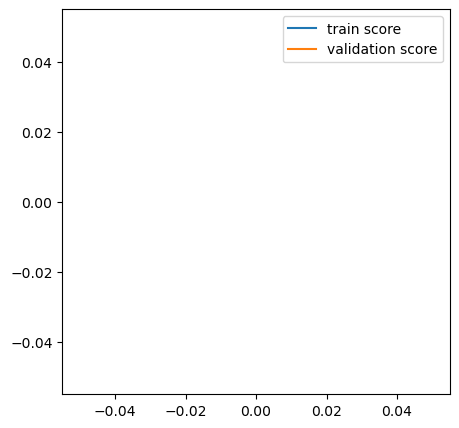

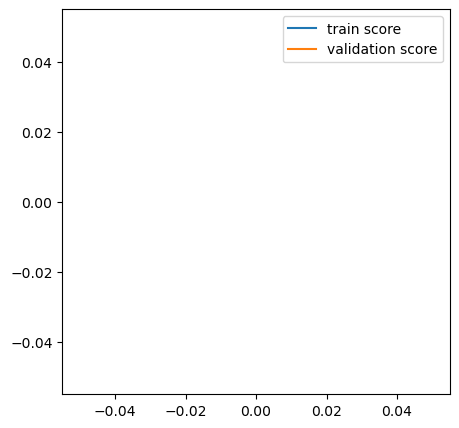

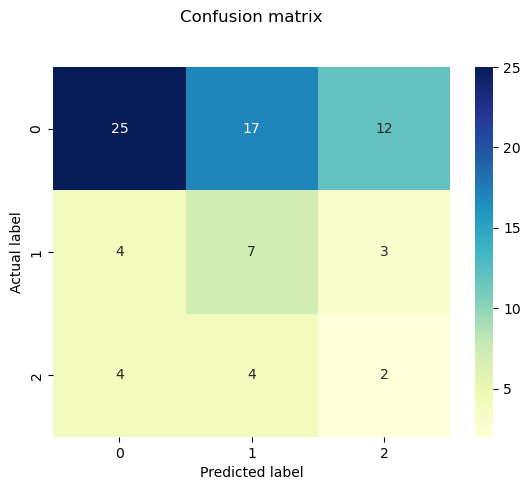

0.5468193990559187


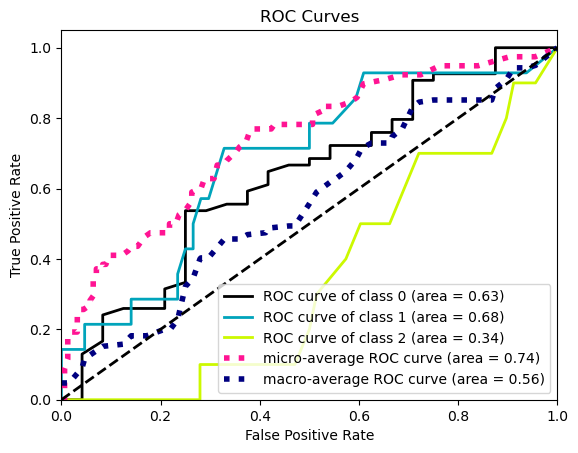

---------------------------------
LR
Accuracy =  0.5
-
[[31 13 10]
 [ 2  7  5]
 [ 6  3  1]]
-
              precision    recall  f1-score   support

           0       0.79      0.57      0.67        54
           1       0.30      0.50      0.38        14
           2       0.06      0.10      0.08        10

    accuracy                           0.50        78
   macro avg       0.39      0.39      0.37        78
weighted avg       0.61      0.50      0.54        78

-


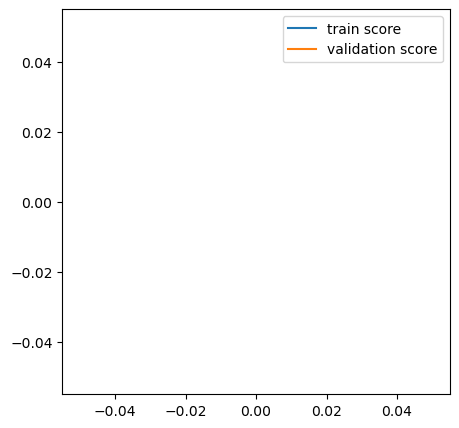

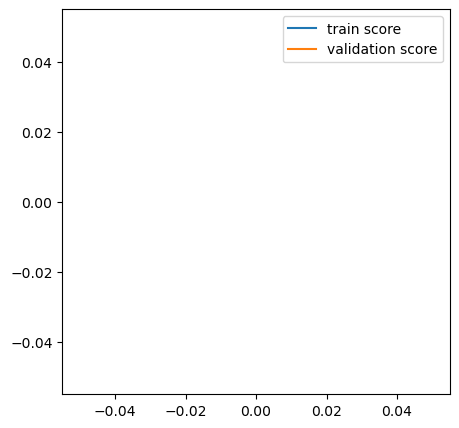

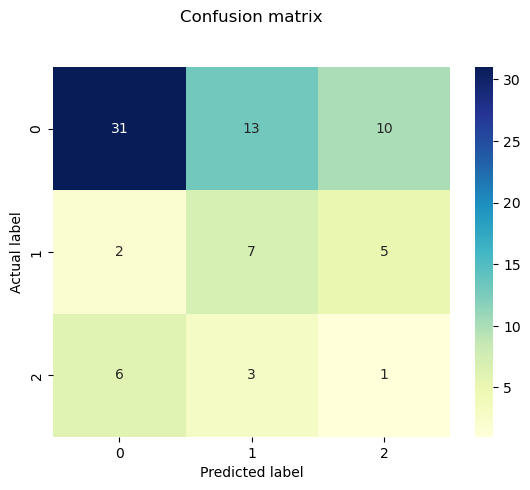

0.5616920842411038


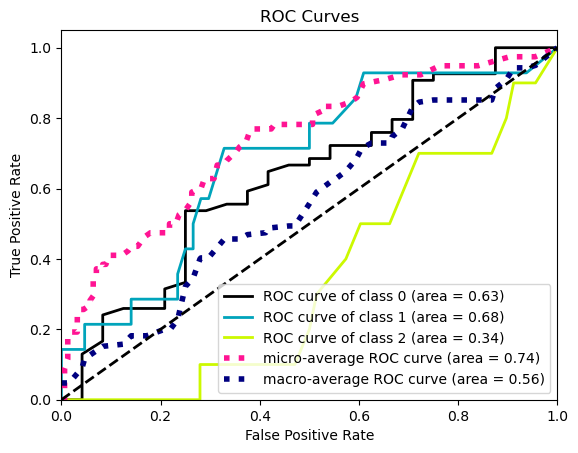

In [22]:
for name, model in dict_of_models.items():
    print('---------------------------------')
    print(name)
    evaluation(model)

## Using RandomForest

In [23]:
RandomPipeline.fit(X_train, y_train)
y_proba = RandomPipeline.predict_proba(X_test)
y_pred = np.argmax(y_proba,axis=1)
print("RandomForest : ", accuracy_score(y_test, y_pred))

RandomForest :  0.5256410256410257


In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


In [25]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [26]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.5370410895839818


Text(0.5, 23.52222222222222, 'Predicted label')

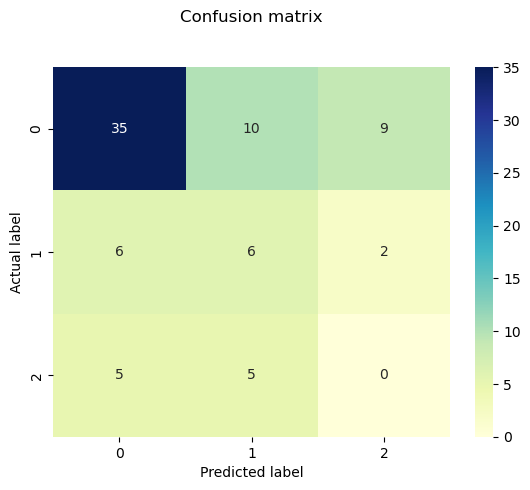

In [27]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

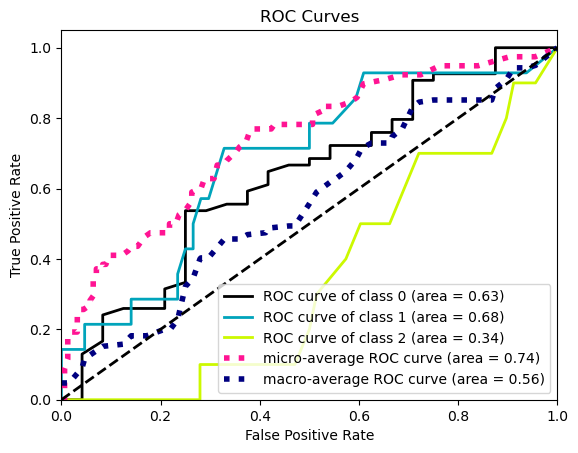

In [28]:
from sklearn.metrics import roc_curve
y_pred_keras_pr = RandomPipeline.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_pr)

### Optimization

In [29]:
from sklearn.model_selection import RandomizedSearchCV
RandomPipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'randomforestclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__minmaxscaler', 'pipeline__minmaxscaler__clip', 'pipeline__minmaxscaler__copy', 'pipeline__minmaxscaler__feature_range', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [30]:
hyper_params = {
    'randomforestclassifier__n_estimators':[10,100,150,250,400,600],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__min_samples_split':[2,6,12],
    'randomforestclassifier__min_samples_leaf':[1,4,6,10],
    'randomforestclassifier__max_features':['auto','srqt','log2',int,float],
    'randomforestclassifier__n_jobs':[-1],
    'randomforestclassifier__verbose':[0,1,2],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
    'randomforestclassifier__n_jobs':[-1],
}

In [31]:
RF_grid = RandomizedSearchCV(RandomPipeline,hyper_params,scoring='accuracy',n_iter=40)
RF_grid.fit(X_train,y_train)
ypred = RF_grid.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent worker

In [32]:
print(classification_report(y_test,ypred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.65      0.70        54
           1       0.29      0.43      0.34        14
           2       0.00      0.00      0.00        10

    accuracy                           0.53        78
   macro avg       0.35      0.36      0.35        78
weighted avg       0.58      0.53      0.55        78

0.5256410256410257


## Using XGBoost

In [35]:
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # finding the predicted valued
    y_pred = np.argmax(y_pred_proba,axis=1)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

In [36]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
     learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     eval_metric = 'logloss',
     nthread= -1,
     scale_pos_weight=1).fit(X_train, y_train)
evaluation (gbm)

Accuracy =  0.5
-
[[32 11 11]
 [ 6  7  1]
 [ 5  5  0]]
-
              precision    recall  f1-score   support

           0       0.74      0.59      0.66        54
           1       0.30      0.50      0.38        14
           2       0.00      0.00      0.00        10

    accuracy                           0.50        78
   macro avg       0.35      0.36      0.35        78
weighted avg       0.57      0.50      0.52        78

-


In [37]:
y_pred = gbm.predict(X_test)

In [38]:
#! pip install scikit-plot
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [39]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5
              precision    recall  f1-score   support

           0       0.74      0.59      0.66        54
           1       0.30      0.50      0.38        14
           2       0.00      0.00      0.00        10

    accuracy                           0.50        78
   macro avg       0.35      0.36      0.35        78
weighted avg       0.57      0.50      0.52        78



Text(0.5, 23.52222222222222, 'Predicted label')

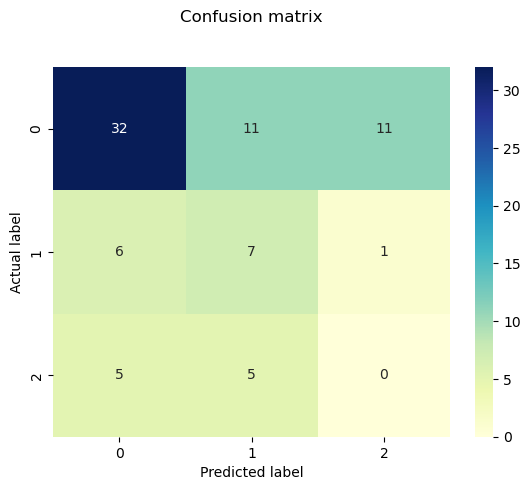

In [40]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [42]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [43]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.5346314451706609


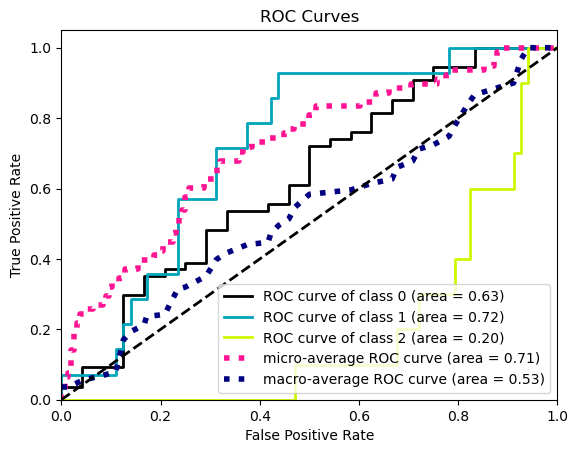

In [44]:
from sklearn.metrics import roc_curve
y_pred_keras_pr = gbm.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_pr)